In [19]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from skimage.io import imread

In [20]:
EPOCHS=100
BATCH_SIZE=8
SAMPLES_PER_GROUP=2000
AUGMENT_BRIGHTNESS = False
TRAIN_DIR = '../input/airbus-ship-detection/train_v2'
MASK_FILE = '../input/airbus-ship-detection/train_ship_segmentations_v2.csv'

In [21]:
train_image_dir = os.path.join('../input/airbus-ship-detection', 'train_v2')
test_image_dir = os.path.join('../input/airbus-ship-detection', 'test_v2')
masks = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [22]:
print(masks.head())
print(masks.shape)

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
(231723, 2)


Each line is an encoded record of the vessel position in the image. If the EncodedPixels value is NaN, it means that there are no ships in the image. 

Each line is an encoded record of the vessel position in the image. If the EncodedPixels value is NaN, it means that there are no ships in the image. 

In [23]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [24]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_images = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
masks.drop(['ships'], axis=1, inplace=True)
unique_images.sample(10)

,ImageId,ships
86519,72eb31eb1.jpg,0
173561,e6d56fa60.jpg,0
180321,efd7bad17.jpg,0
116403,9aba85b9f.jpg,0
62116,52b8a6b7b.jpg,2
65240,56de4bb74.jpg,0
88527,7583116cd.jpg,0
129754,ac86de0f1.jpg,0
61128,517ea15c7.jpg,0
6357,0875e5bd7.jpg,0


In [25]:
unique_images.shape

(192556, 2)

Convert the dataframe into a list of unique values of image identifiers and the corresponding number of ships on it. We have information about 192556 images.

<Axes: >

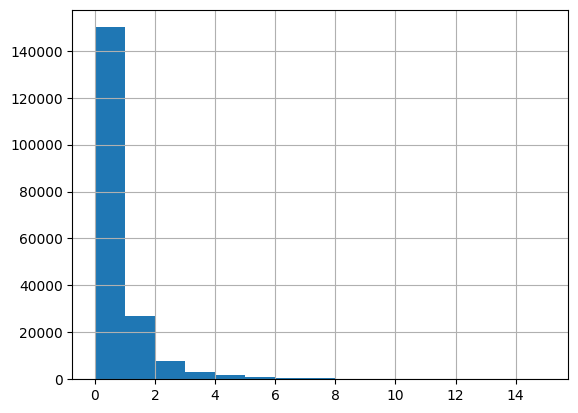

In [26]:
unique_images['ships'].hist(bins=unique_images['ships'].max())

The graph shows the distribution of the number of ships. It can be seen that most of the images contain one ship or nothing.

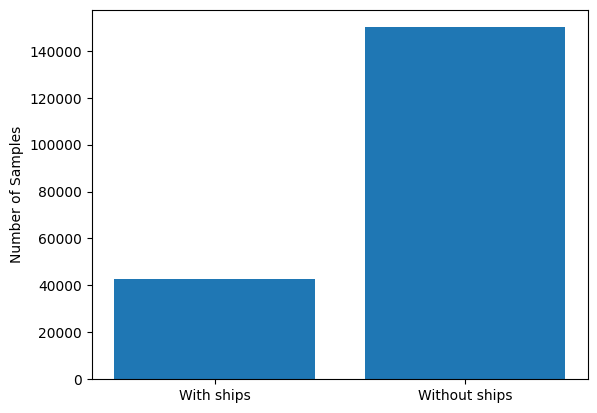

In [27]:
ships = masks[~masks.EncodedPixels.isna()].ImageId.unique()
noships = masks[masks.EncodedPixels.isna()].ImageId.unique()

plt.bar(['With ships', 'Without ships'], [len(ships), len(noships)]);
plt.ylabel('Number of Samples');

Let's look at this in more detail, about 140000 samples do not contain any ships.

Lets explore some samples

In [28]:
balanced_train_df = unique_images.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)

In [29]:
train_ids, valid_ids = train_test_split(balanced_train_df, 
                                        test_size = 0.2,
                                        stratify = balanced_train_df['ships'])

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)

In [30]:
data = train_df.groupby('ImageId')
X = [x for x, y in data]
y = [y['EncodedPixels'].values for x, y in data]

In [31]:
batch_X = np.stack([imread(os.path.join(TRAIN_DIR, img))/255 for img in X[0:4]],0)
batch_y = np.stack([np.expand_dims(masks_as_image(mask), -1) for mask in y[0:4]],0)

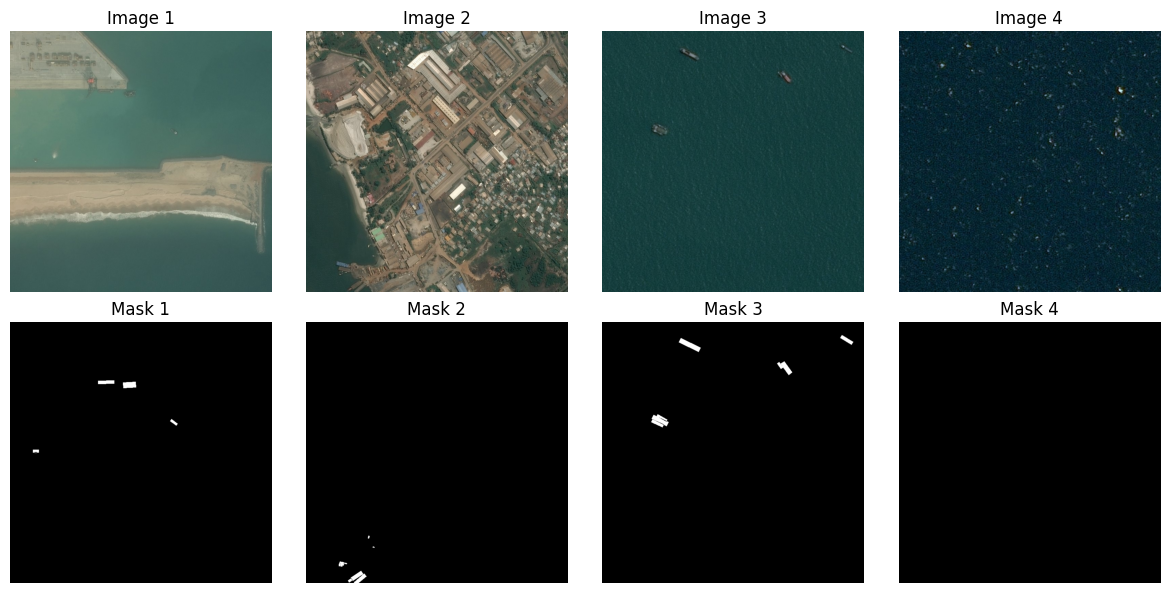

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, (image, mask, ax) in enumerate(zip(batch_X, batch_y, axes.T)):
    ax[0].imshow(image)
    ax[0].set_title(f'Image {i + 1}', fontsize=12)
    ax[0].axis('off')

    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title(f'Mask {i + 1}', fontsize=12)
    ax[1].axis('off')

plt.tight_layout()
plt.show()